# DAT340 / DIT867 Applied Machine Learning
## Programming assignment 5

### Amr Mohamed
#### Exchange student from CY Tech - France to GU CSE Department

### Anh Thu DOAN
#### Exchange student from CY Tech - France to GU CSE Department

### Group PA5 10

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,MaxPool2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras import callbacks
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir("/content/drive/My Drive/")

In [6]:
data_gen = ImageDataGenerator(rescale=1.0/255)

In [7]:
imgdir = 'a5_images' # or wherever you put them...
img_size = 64
batch_size = 800

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

val_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [8]:
Xtrain, Ytrain= train_generator.next()
Xval, Yval = val_generator.next()

In [7]:
Xtrain.shape

(800, 64, 64, 3)

In [8]:
Ytrain[4]

1.0

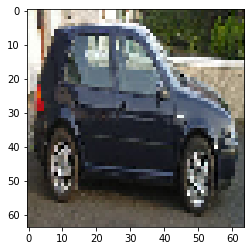

In [9]:
plt.imshow(Xtrain[4])
plt.show()

# Part 1: Training a convolutional neural network

## Baseline Neural network

In [18]:
def make_baseline_convnet():
    model = Sequential()
    model.add(Flatten())
              
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In the cell above, we created a function that creates a baseline neural network that flattens input images and passes them through a dense layer that has relu activation function and outputs a vector of 32 units that are then passed to an output layer that applies the sigmoid function since its a binary classification problem, and for the loss function calculation, we use binary cross entropy (log loss).

In [20]:
baseline_model = make_baseline_convnet()
baseline_history = baseline_model.fit(Xtrain, Ytrain,
          batch_size=200,
          epochs=40,
          verbose=1,
          validation_data=(Xval, Yval)
                   );

Epoch 1/40
4/4 [==============================] - 1s 64ms/step - loss: 2.3278 - accuracy: 0.5138 - val_loss: 2.3757 - val_accuracy: 0.5000
Epoch 2/40
4/4 [==============================] - 0s 19ms/step - loss: 1.6117 - accuracy: 0.5050 - val_loss: 0.8312 - val_accuracy: 0.5000
Epoch 3/40
4/4 [==============================] - 0s 18ms/step - loss: 0.7261 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/40
4/4 [==============================] - 0s 19ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/40
4/4 [==============================] - 0s 19ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/40
4/4 [==============================] - 0s 19ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/40
4/4 [==============================] - 0s 19ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/40
4/4 [===========

In [13]:
baseline_acc = baseline_history.history['accuracy']
baseline_val_acc = baseline_history.history['val_accuracy']
baseline_loss = baseline_history.history['loss']
baseline_val_loss = baseline_history.history['val_loss']
# epochs_range=range(cb.stopped_epoch+1)
epochs_range=range(40)

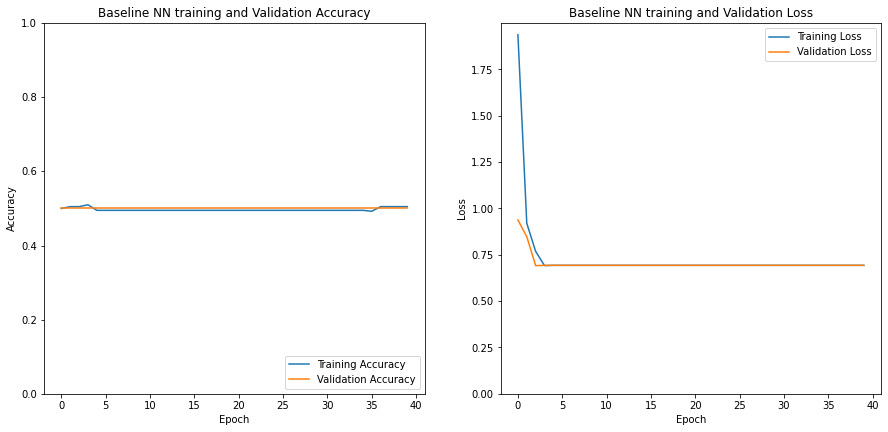

In [17]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, baseline_acc, label='Training Accuracy')
plt.plot(epochs_range, baseline_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Baseline NN training and Validation Accuracy')
plt.ylim(bottom=0,top=1)
plt.subplot(2, 2, 2)
plt.plot(epochs_range, baseline_loss, label='Training Loss')
plt.plot(epochs_range, baseline_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Baseline NN training and Validation Loss')
plt.ylim(bottom=0)
plt.show()

From the 2 graphs above, we can see that the Baseline classifier neural network had training and validation accuracies of approximately 50% over the 40 epochs, similarly, the neuarl netwok had a training loss approximatly equal to 2.3 at the first epoch ,while the validation loss was equal to approximately 1 at the first epoch, and after the 3rd epoch, the training and validation loss converged to 0.69 and stayed constant between the 4th and the 40th epochs. (The choice 40 epochs came through trail and error with all the parts of the assignment, and will be held constant with the rest versions of CNNs to compare the different CNNs with each other.

In [21]:
def make_convnet(img_width, img_height,num_classes):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(img_width, img_height, 3),kernel_regularizer =regularizers.l2( l=0.01)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    model.add(Conv2D(128, (5, 5), 
              activation='relu',
              kernel_regularizer =regularizers.l2( l=0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
              
    model.add(Flatten())
              
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [22]:
model = make_convnet(64,64,2)
history = model.fit(Xtrain, Ytrain,
          batch_size=200,
          epochs=40,
          verbose=1,
          validation_data=(Xval, Yval)
                   );

Epoch 1/40
4/4 [==============================] - 12s 246ms/step - loss: 1.5422 - accuracy: 0.4850 - val_loss: 1.3903 - val_accuracy: 0.5000
Epoch 2/40
4/4 [==============================] - 0s 81ms/step - loss: 1.3236 - accuracy: 0.5100 - val_loss: 1.2204 - val_accuracy: 0.5000
Epoch 3/40
4/4 [==============================] - 0s 79ms/step - loss: 1.1599 - accuracy: 0.5575 - val_loss: 1.0757 - val_accuracy: 0.6927
Epoch 4/40
4/4 [==============================] - 0s 74ms/step - loss: 1.0211 - accuracy: 0.6712 - val_loss: 0.9502 - val_accuracy: 0.6840
Epoch 5/40
4/4 [==============================] - 0s 64ms/step - loss: 0.9136 - accuracy: 0.6625 - val_loss: 0.8609 - val_accuracy: 0.6927
Epoch 6/40
4/4 [==============================] - 0s 64ms/step - loss: 0.8059 - accuracy: 0.6888 - val_loss: 0.8007 - val_accuracy: 0.6892
Epoch 7/40
4/4 [==============================] - 0s 65ms/step - loss: 0.7161 - accuracy: 0.7325 - val_loss: 0.7822 - val_accuracy: 0.6667
Epoch 8/40
4/4 [=========

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# epochs_range=range(cb.stopped_epoch+1)
epochs_range=range(40)

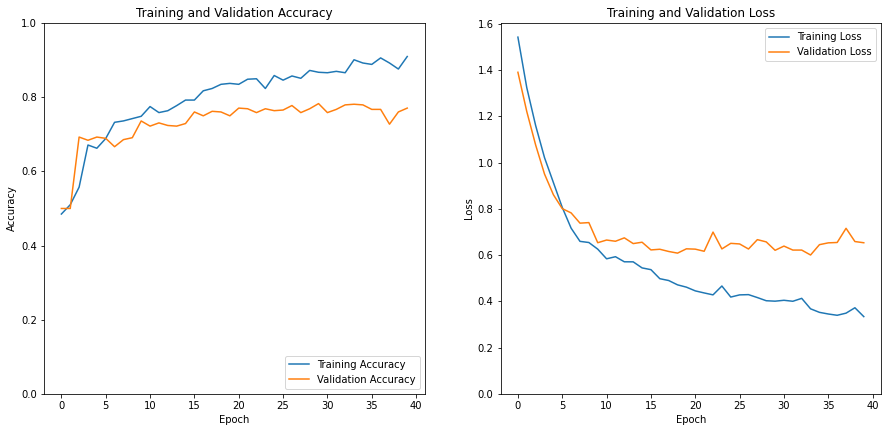

In [25]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(bottom=0,top=1)
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(bottom=0)

plt.show()

We can see that with a bactch size of 200, the NN overfits after the 5th epoch, and we can see that the validation accuracy is maximized at the 30th epoch. Therefore, when retraining the NN, we should consider training the NN for 30 epochs, since we can see that at the 30th epoch, the validation accuracy is 78.3% approximately, and the training accuracy is 86% approximately. In addition, the loss curves for both CNNs had the same trend over the 40 epochs, but since the NN didn't generalize well, we can see the effect of overfitting in the loss curves as the training loss reached its minimum at the 40th epoch were it was equal to 0.3, while the validation loss was equal to 0.65. The generalization gap at this point is high enough to investigate the model's overfitting and consider an overfitting reduction technique such as data augmentation.

# Part 2: Data augmentation

In [247]:
DAu_gen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.5,
        zoom_range=0.05,
        channel_shift_range=0.5)

train_generator_DAu=DAu_gen.flow_from_directory(
            imgdir + '/train',
            target_size=(img_size, img_size),
            batch_size=batch_size,
            class_mode='binary',
            classes=['other', 'car'],
            seed=12345,
            shuffle=True)

Xtrain_aug,Ytrain_aug = train_generator_DAu.next()

Found 1600 images belonging to 2 classes.


In [248]:
#shape of the augmented data, 800 rgb images with dimensions 64x64 
Xtrain_aug.shape

(800, 64, 64, 3)

In [249]:
Xtrain.shape

(800, 64, 64, 3)

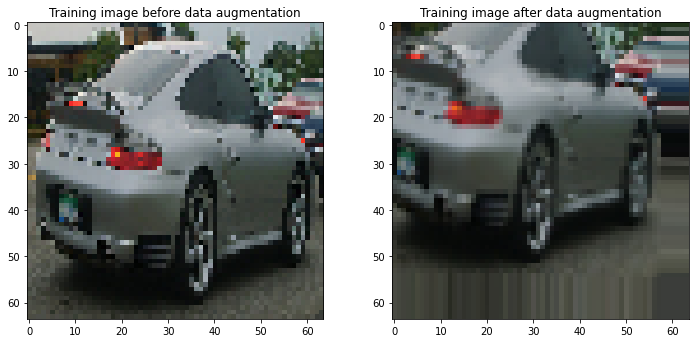

In [250]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(Xtrain[0])
plt.title('Training image before data augmentation')
plt.subplot(2, 2, 2)
plt.imshow(Xtrain_aug[0])
plt.title('Training image after data augmentation')
plt.show()

In [251]:
aug_model = make_convnet(64,64,2)
aug_history = aug_model.fit(Xtrain_aug, Ytrain_aug,
          batch_size=200,
          epochs=40,
          verbose=1,
          validation_data=(Xval, Yval));

Epoch 1/40
4/4 [==============================] - 1s 138ms/step - loss: 1.6885 - accuracy: 0.4963 - val_loss: 1.4467 - val_accuracy: 0.5000
Epoch 2/40
4/4 [==============================] - 0s 71ms/step - loss: 1.3744 - accuracy: 0.4950 - val_loss: 1.2890 - val_accuracy: 0.5000
Epoch 3/40
4/4 [==============================] - 0s 69ms/step - loss: 1.2438 - accuracy: 0.4950 - val_loss: 1.1783 - val_accuracy: 0.5000
Epoch 4/40
4/4 [==============================] - 0s 68ms/step - loss: 1.1384 - accuracy: 0.5312 - val_loss: 1.0840 - val_accuracy: 0.5122
Epoch 5/40
4/4 [==============================] - 0s 66ms/step - loss: 1.0608 - accuracy: 0.5688 - val_loss: 1.0222 - val_accuracy: 0.6389
Epoch 6/40
4/4 [==============================] - 0s 65ms/step - loss: 0.9996 - accuracy: 0.5763 - val_loss: 0.9870 - val_accuracy: 0.5833
Epoch 7/40
4/4 [==============================] - 0s 64ms/step - loss: 0.9692 - accuracy: 0.5813 - val_loss: 0.9575 - val_accuracy: 0.5417
Epoch 8/40
4/4 [==========

In [252]:
acc = aug_history.history['accuracy']
val_acc = aug_history.history['val_accuracy']
loss = aug_history.history['loss']
val_loss = aug_history.history['val_loss']
epochs_range=range(40)

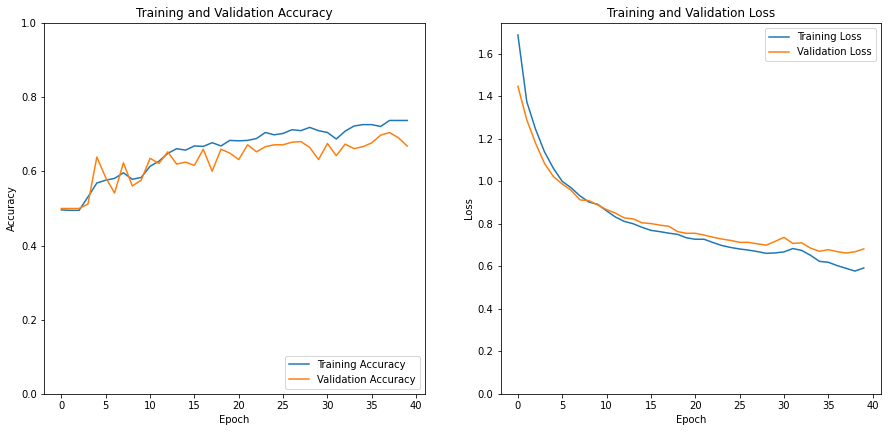

In [253]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(bottom=0,top=1)
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(bottom=0)

plt.show()

From the cell above, we can see that by applying data augmentation, the generalization gap decreased significantly in both the accuracies and losses curves, while there was a slight decrease in the accuracy of the model due to the inability to find all the patterns in the batch used due to the insufficiency of the data, However, the decrease is slight and we may consider using this model due to its better ability in generlization.

## Interlude: Applying a pre-trained convolutional neural network

In [33]:
instance = load_img('./a5_images/validation/car/0000.jpg', target_size=(224,224))
instance_arr = img_to_array(instance)
proc_instance= preprocess_input(instance_arr)
proc_instance_reshaped = proc_instance.reshape(1, 224, 224, 3)

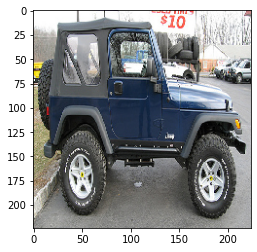

In [34]:
plt.imshow(instance)
plt.show()

In [38]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)
instance_guess=vggmodel.predict(proc_instance_reshaped)
for i in decode_predictions(instance_guess)[0]:
    print(i[1] +': '+str(round(i[2]*100,2))+'%')

49152/35363 [=========================================] - 0s 0us/step
jeep: 92.14%
snowplow: 2.43%
golfcart: 1.44%
pickup: 1.27%
half_track: 0.53%


Using the VGG-16 model, the model was able to identify a Jeep car, as jeep specifically, with accuracy 92.14%.

# Part 3: Using VGG-16 as a feature extractor

In [39]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [40]:
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
def create_vgg16_features(feature_extractor, vgg_data_gen, path, write_file, batch_size):
    
    generator = vgg_data_gen.flow_from_directory(
        path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        seed=12345,
        shuffle=False)
    
    cnn_features = feature_extractor.predict(generator)
    
    with open(write_file, 'wb') as f:
        np.save(f, cnn_features)

In [41]:
vgg_train_features = create_vgg16_features(feature_extractor=feature_extractor,
                                           vgg_data_gen=vgg_data_gen,
                                           path='./a5_images/train',
                                           write_file='train_features',
                                           batch_size=32)

vgg_val_features = create_vgg16_features(feature_extractor=feature_extractor,
                                           vgg_data_gen=vgg_data_gen,
                                           path='./a5_images/validation',
                                           write_file='val_features',
                                           batch_size=32)

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [42]:
def get_labels(n):
    return np.array([0] * (n // 2) + [1] * (n // 2))

In [61]:
def train_on_cnnfeatures(train_file,val_file):
    
    with open(train_file, 'rb') as f:
        train_data = np.load(f)
        
    with open(val_file, 'rb') as f:
        val_data = np.load(f)
    
    model = Sequential()
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
    
    history = model.fit(train_data,get_labels(len(train_data)),
          batch_size=200,
          epochs=40,
          verbose=1
          ,validation_data=(val_data,get_labels(len(val_data)))
                       );
    
    return model,history

In the cell above, we created the function train_on_cnnfeatures that takes as arguments the training and validation data files, and outputs a CNN with its training and validation information. After calling the function sequential from keras, we flatten the image and pass it through 2 dense layer of 128 and 32 units, and with activation functions relu and tanh respectively, and finaly its passed to the output layer that applies the sigmoid function since its a binary classification problem, and for the loss function calculation, we use binary cross entropy (equivalent to log loss). Finally, when fitting the model we specify the epoch range as 40 epochs and batch size equal to 200 to compare it with earlier implemented CNNs.

In [62]:
vgg_model,vgg_history = train_on_cnnfeatures('train_features','val_features')

Epoch 1/40
8/8 [==============================] - 1s 30ms/step - loss: 0.4791 - accuracy: 0.7631 - val_loss: 0.3324 - val_accuracy: 0.8628
Epoch 2/40
8/8 [==============================] - 0s 6ms/step - loss: 0.2424 - accuracy: 0.9031 - val_loss: 0.3118 - val_accuracy: 0.8767
Epoch 3/40
8/8 [==============================] - 0s 7ms/step - loss: 0.1908 - accuracy: 0.9206 - val_loss: 0.2761 - val_accuracy: 0.8924
Epoch 4/40
8/8 [==============================] - 0s 8ms/step - loss: 0.1547 - accuracy: 0.9413 - val_loss: 0.2671 - val_accuracy: 0.8976
Epoch 5/40
8/8 [==============================] - 0s 8ms/step - loss: 0.1373 - accuracy: 0.9519 - val_loss: 0.2626 - val_accuracy: 0.8976
Epoch 6/40
8/8 [==============================] - 0s 7ms/step - loss: 0.1154 - accuracy: 0.9625 - val_loss: 0.2500 - val_accuracy: 0.8958
Epoch 7/40
8/8 [==============================] - 0s 7ms/step - loss: 0.1015 - accuracy: 0.9656 - val_loss: 0.2571 - val_accuracy: 0.8941
Epoch 8/40
8/8 [=================

In [63]:
vgg_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']
vgg_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']
vgg_epochs_range=range(40)

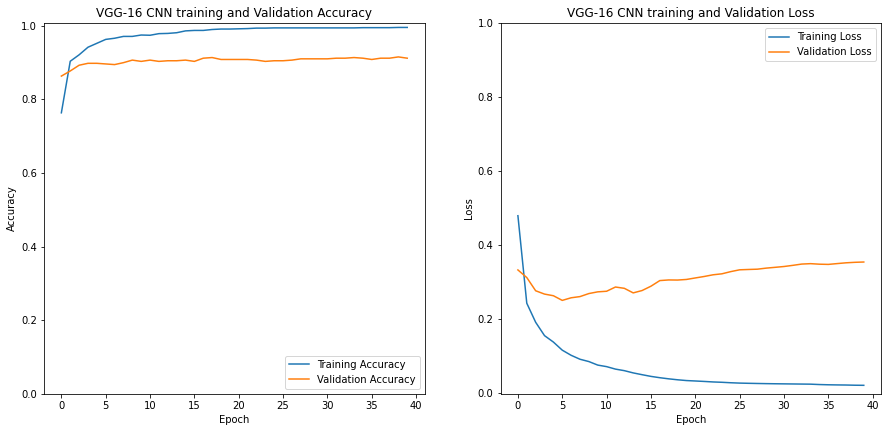

In [64]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(vgg_epochs_range, vgg_acc, label='Training Accuracy')
plt.plot(vgg_epochs_range, vgg_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('VGG-16 CNN training and Validation Accuracy')
plt.ylim(bottom=0)
plt.subplot(2, 2, 2)
plt.plot(vgg_epochs_range, vgg_loss, label='Training Loss')
plt.plot(vgg_epochs_range, vgg_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG-16 CNN training and Validation Loss')
plt.ylim(top=1)

plt.show()

From the cell above, we can see that using transfer learning with the VGG-16 CNN, the the model shows a significant improvent in the accuracy where the training and validation accuracies reached approximately 100% and 91% respectively, and the training and testing losses were minmized to approximately 0 and 0.4  at the 40th epoch respectively compared to the CNNs applied earlier, however, it still overfits as the model doesn't used the overfitting data augmentation method used earlier. If we consider to use this model, we can consider applying early stoppingat the 2nd epoch were there is a very little generalization gap between the training and validation accuracies and losses curves.

# Part 4: Visualizing the learned features

In [65]:
first_layer_weights = feature_extractor.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [66]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

In the cell below, we made a loop to plot at each epoch the filters pair, positive and negative, of the first layer weights, where dark squares indicate small weights and light squares represent large weights, while the colors alternate between red, green, and blue, as well as, mixture and intersections of them since the images are in rgb format.

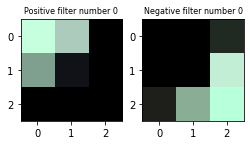

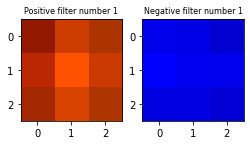

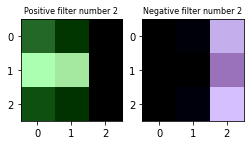

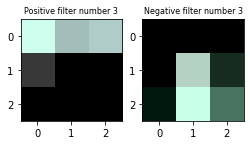

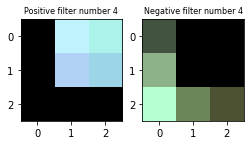

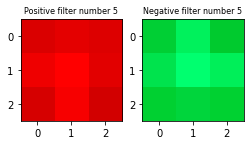

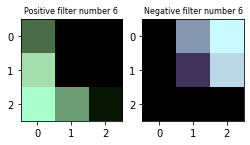

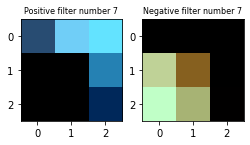

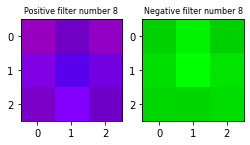

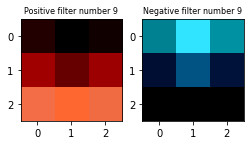

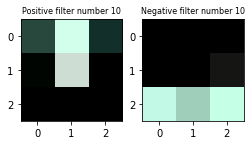

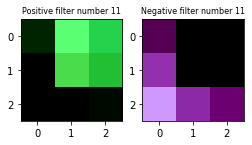

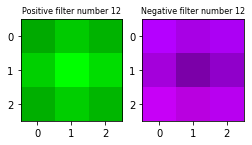

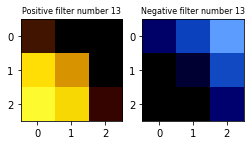

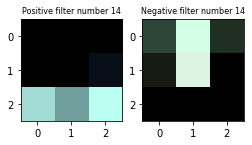

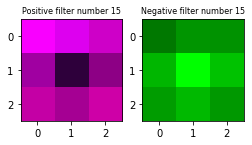

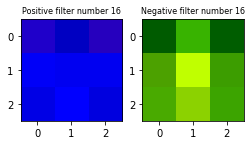

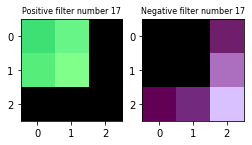

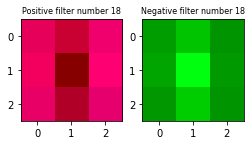

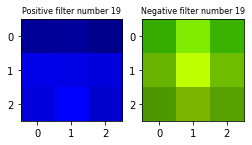

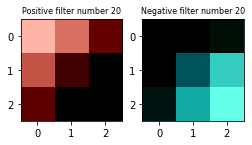

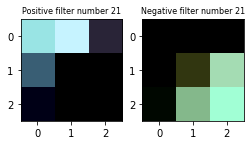

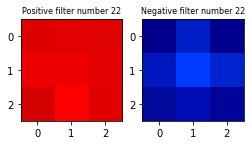

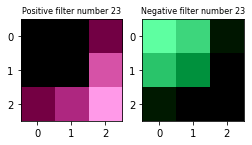

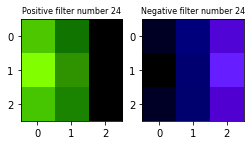

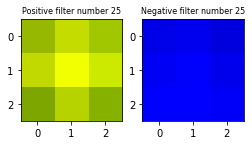

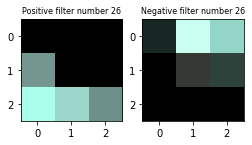

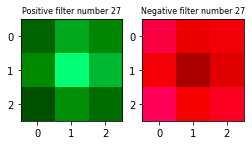

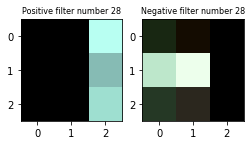

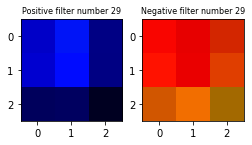

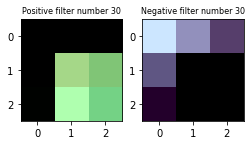

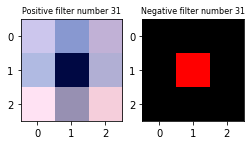

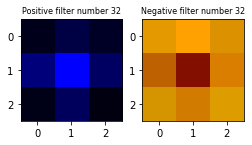

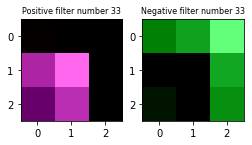

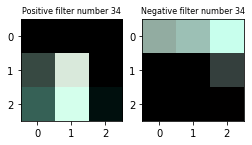

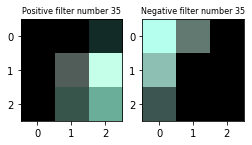

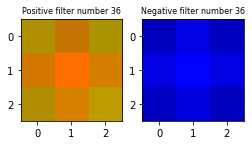

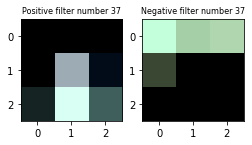

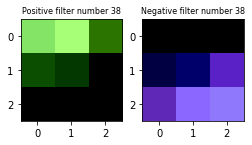

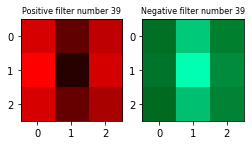

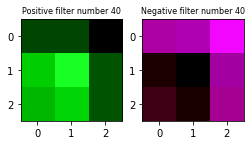

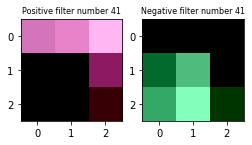

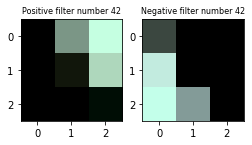

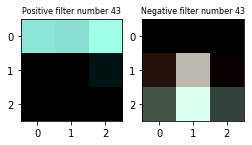

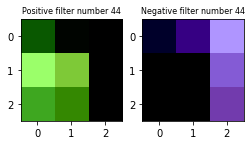

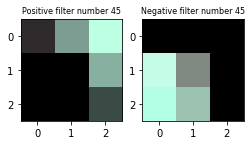

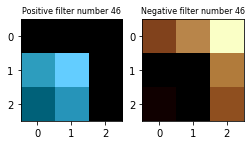

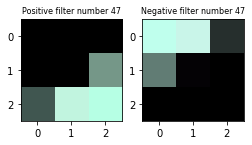

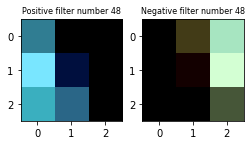

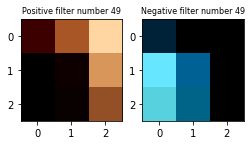

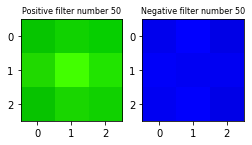

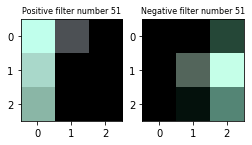

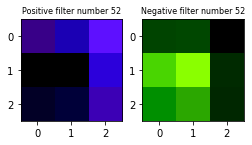

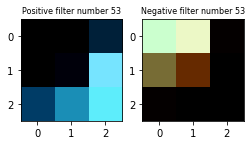

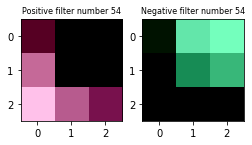

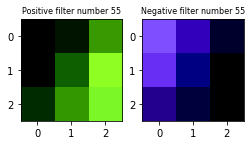

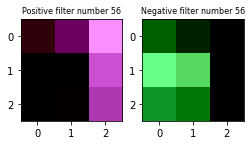

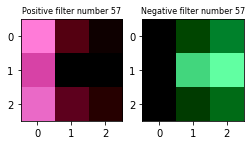

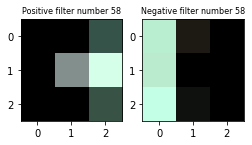

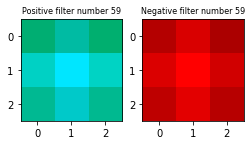

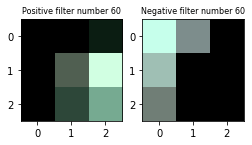

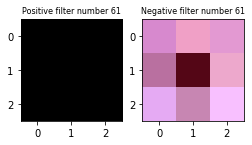

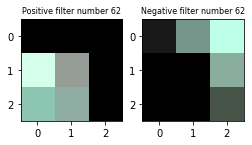

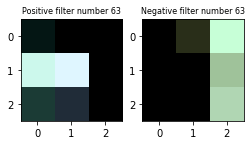

In [68]:
for i in range(64):
    plt.figure(figsize=(4, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(kernel_image(first_layer_weights, i, True))
    plt.title("Positive filter number "+str(i),fontdict={'fontsize': 8})

    plt.subplot(1, 2, 2)
    plt.imshow(kernel_image(first_layer_weights, i, False))
    plt.title("Negative filter number "+str(i),fontdict={'fontsize': 8})

    plt.show()